## 阶段一：2024.7.11~2024.7.16, 研报解读与分享

近期工作：
1. 可转债研报的分析：了解了不同的可转债多因子模型
2. DTW算法的分析

### DTW择时策略

DTW(Dynamic time warping)，中文为**动态时间规整算法**，用于对比两个信号之间的相关性。

#### 1. **DTW和其他相似性算法的区别和优势是什么？**

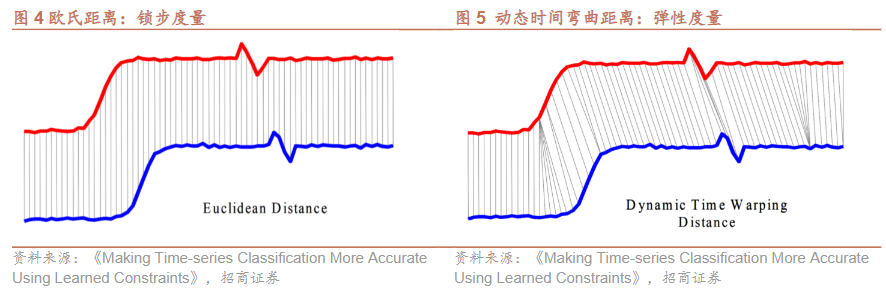

如图所示，左边是使用一对一的方式进行。这种方法的缺陷是如果两个信号有延迟，就会导致错配的问题。DTW算法解决了这个问题。

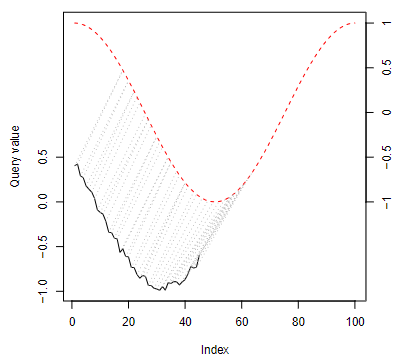

普通的相似性算法很多对序列的长度比较敏感，比如相关系数的计算，如果两个序列长度不同，会很大地影响准确度。而DTW算法可以很好地解决这个问题。

#### 2. **DTW的核心算法是什么？**

DTW的核心逻辑是使用动态规划的算法，通过扭曲时间轴，来实现两个时间序列的匹配。
- 算法简述如下：
1. 遍历两个序列A和B的每一个值，计算每一对值$ (i, j) $的累计值$ D(i, j) $，其中$ d(a_i, b_j) $是两个点之间的距离

$ A = \{a_1, a_2, \ldots, a_n\} $ and $ B = \{b_1, b_2, \ldots, b_m\} $

$ D(i, j) = d(a_i, b_j) + \min \begin{cases}
D(i-1, j) \\
D(i, j-1) \\
D(i-1, j-1)
\end{cases} $

2. 计算完成之后，就形成了如下的**Cost矩阵**，为了找出最优的匹配路径，我们使用动态规划算法，最终形成了红色的这一条线
3. 这一条线代表的是这两个序列之间最优的匹配方式，对应如右图所示
4. 为了比较不同序列之间的相关度，这里引出了一个DTW距离

$ DTW(X, Y) = \frac{\sum_{k=1}^T d(\phi_x(k), \phi_y(k))m_{\phi}(k)}{M_{\phi}} $

其中$\phi(𝑘)$ 是最短路径的匹配，$ m_{\phi}(k) $是权重， $ M_{\phi} $是标准化系数

$ \phi(𝑘)=(\phi_𝑥(𝑘),\phi_𝑦(𝑘)) $

$ \phi_𝑥(𝑘)\in {1,...,𝑁} $

$ \phi_𝑦(𝑘)\in {1,...,𝑀} $

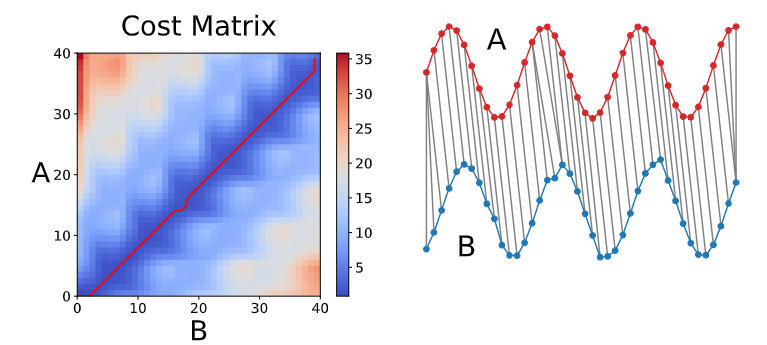

#### 3. **DTW的改进**

“病态匹配”问题：

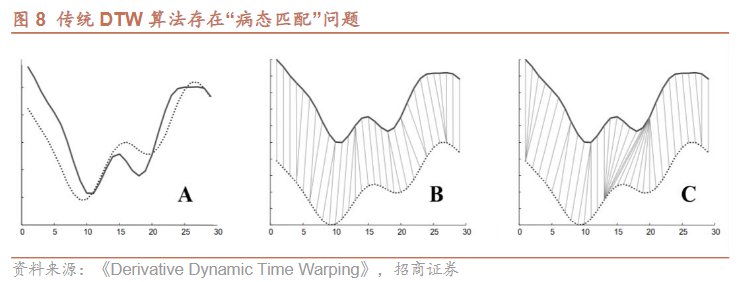

方法1：添加区域限制

**Sakoe-Chiba Constraint**和**Itakura Parallelogram**区域限制

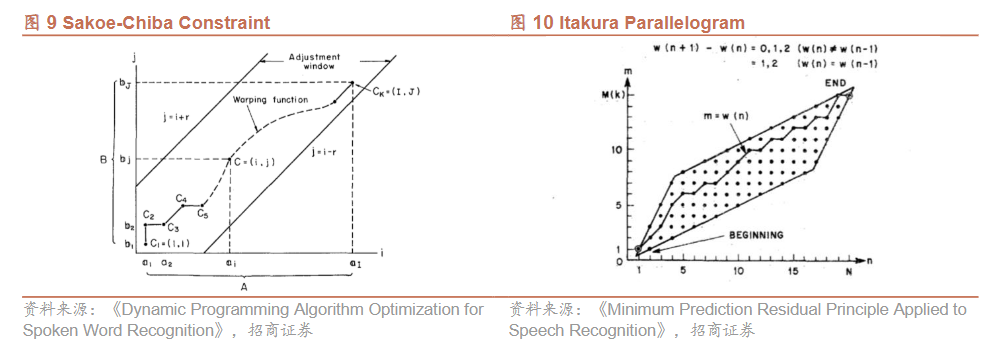

方法2：添加权重

回顾之前的DTW距离公式，我们可以对路径的每一步添加权重进行限制

$ DTW(X, Y) = \frac{\sum_{k=1}^T d(\phi_x(k), \phi_y(k))m_{\phi}(k)}{M_{\phi}} $

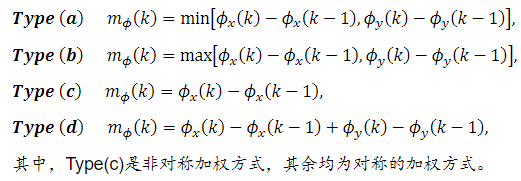

#### **4. 策略**

沪深300，选取指数收盘价和成交量，调仓周频。在调仓日，计算当上一段时间的收盘价和成交量与历史序列的DTW 离，筛选相似度较高（即DTW 距离较小）的部分历史序列，根据历史序列未来一周的加权平均涨跌幅（权重=1/DTW 距离）对未来一周行情做出预判，**即若历史序列未来加权平均涨跌幅>0，发出看多信号，反之，发出看空信号**。另外，若未筛选出相似的历史序列，则延续上一交易日的择时信号。 

*使用遍历法找出最佳的参数(l为序列长度，k为DTW距离阈值)*。

1. **传统DTW策略**
2. **基于区域的限制的DTW策略**
3. **基于添加权重的DTW策略**
   - 周频和日频
4. **引入宏观流动性指标的DTW策略**
   - 周频和日频
   - 沪深300股指期货
   - 其他宽基指数

> M1和M2（同比增速）的剪刀差反映货币供应量结构的变化，是能够把握市场拐点的一个宏观流动性指标。

可以基于M1 和M2 剪刀差的历史分位值构建择时策略：若剪刀差指标低于阈值，发出看多信号，反之发出看空信号。样本内测试结果显示当阈值为20%时，择时收益最高，故后面我们以20%作为判断市场底部的阈值对Ita-DTW择时策略进行优化。

#### **5.结论**

使用引入宏观流动性指标的、添加区域限制的DTW策略表现最好。

---

## 阶段二：2024.7.16~2024.11.8, 研报复现

基本原理和回测逻辑解析：

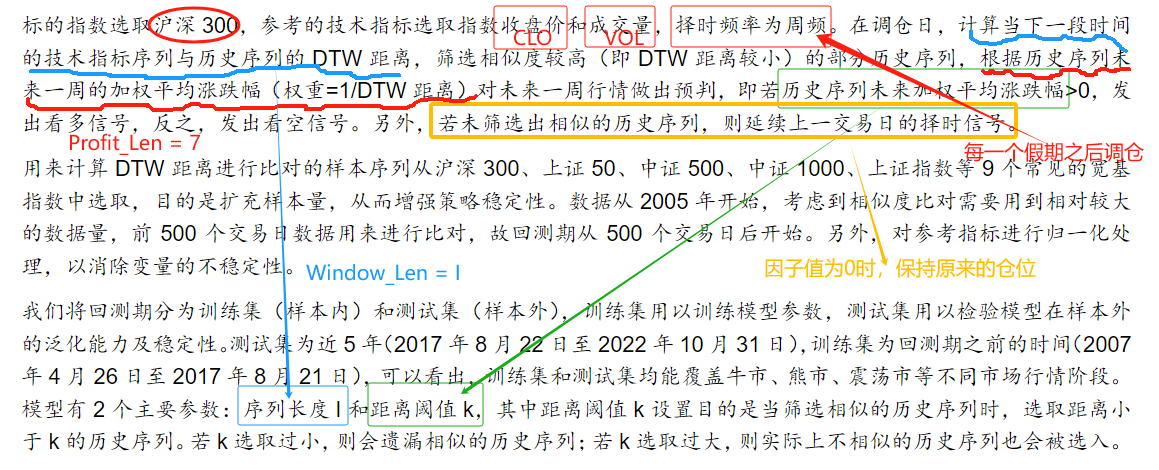

### 代码模块

- **基础数据处理模块**
  - `Trade_Calendar`: 交易日历获取函数(需要用到线上数据库)
  - `Position_Changing_Date`: 调仓日期获取函数(日频、周频、月频)。其中日频等同于整个交易日历；周频为一周中第一个交易工作日；月频为一个月中第一个交易日。
    - `Date_Range_Filter`: 日期过滤器，用于选出日期列表中指定的日期范围。在这个算法中，用于筛选训练日期和测试日期。
  - 训练日期、测试日期、回测日期
  - `Get_Price`: 获取HS300量价数据函数(需要用到线上数据库)，包含开盘价、收盘价和交易量。Dataframe的列从左到右为trade_date, ts_code, OPEN, CLOSE, VOLUME.
  - `Find_Missing_Items`: 寻找缺失值的函数，主要功能是找出在交易日历范围内有缺失数据的标的
  - `Get_Reference`: 获取对比数据函数(需要用到线上数据库)，标的有："000300.SH", "000905.SH", "000852.SH", "000016.SH", "399330.SZ", "000001.SH", "399001.SZ", "399006.SZ". 包含开盘价、收盘价和交易量。Dataframe的列从左到右为trade_date, ts_code, OPEN, CLOSE, VOLUME
  - `Get_Benchmark`: 获取基准数据函数(需要用到线上数据库)，即：HS300, ZZ500, ZZ1000.  包含开盘价、收盘价和交易量
  - `Get_Return`: 计算收益率的函数. 其中收益率的计算方式为：第一天的收益率为$\frac{CLOSE_{today} - OPEN_{today}}{OPEN_{today}}$，往后每天的收益率为$\frac{CLOSE_{today} - CLOSE_{yesterday}}{CLOSE_{yesterday}}$
  - `Get_Delay_Return`: 计算未来收益率的函数，只在Reference_DF中使用，用于后面计算加权因子值，包含参数$Delay$. 要求$Delay < 0$, 即计算未来$|Delay|$天的收益率. *❗❗注意：由于数据有前后的移动，因此计算后会出现Null值，去掉即可*, 得到`Reference_Return`
  - `Calculate_M1M2_Factor`: 生成M1和M2剪刀差因子，因子格式和前面一样

- **算法数值计算模块**：算法数值计算模块的功能仅仅是计算两个序列的"相关性"的值，数据的具体处理交给算法数据处理模块
  - `Calculate_CORR`：CORR模块。最简单的pearson相关性算法，作为对比
  - `Calculate_DTW`: DTW模块。即DTW算法，包括原始的DTW算法、添加了限制边界的DTW算法、添加了权重的DTW算法

- **算法数据处理模块**：算法数据处理模块只处理当个持仓周期的Dataframe，整个持仓周期的数据处理交给因子计算模块。
  - `Calculate_corr`: 计算单个持仓周期的CORR算法因子模块
  - `Calculate_dtw`: 计算单个持仓周期的DTW算法因子模块
> 由于数据格式为Dataframe，因此数据的处理建立在Dataframe上
>
> 有以下指标:
> - `Window_length`: 窗口大小，即待对比序列的长度
> - `Profit_length`: 计算未来收益率的窗口长度
> - `Filter_Type`: 数据过滤的方式，包括Threshold和Rank. Threshold方法为选取在给定数值范围内的值；Rank方法为选取所有数值排序后排序数值在给定排序范围内的值
> - `Scaler`: 数据预处理的方式，包括zscore和minmax
>
> 具体流程为(CORR和DTW流程相同):
> - 某一个长度为`Window_length`的交易量(或价格)序列与整体的`Reference_DF`做滑动窗口计算，窗口长度为`Window_length`. 得到`Corr_DF`，去掉有Null值的行
> - 去掉`Corr_DF`最后`Profit_length`长度的行，得到`Ref_ROI`，以及去掉`Reference_Return`前`Window_length-1`行的数据。这样做是为了将`Corr_DF`与未来收益率`Reference_Return`的长度相匹配。
> - 替换`Corr_DF`中的0值为inf，防止后面计算出现分母为0的情况
> - 使用Threshold或Rank的方法过滤Corr_DF中的数值，得到`Filter_DF`
>   - 使用Rank方法时，使用`Rank_All_DF_Values`函数计算整张Dataframe所有值的排序
> - 计算每一个DTW值的权重1/DTW，得到`Weight_DF`
> - 计算未来的加权平均跌涨幅。使用矩阵点乘，即：`(Filter_DF * Weight_DF) * (Filter_DF * Ref_ROI)`，再将Dataframe中的所有值求和(无关的值已置为0)

- **因子计算模块`Calculate_Factor`**: 对整个持仓周期计算因子值，得到因子Dataframe
> 具体流程为(CORR和DTW流程相同):
> - 使用前面计算出来的交易日期和调仓日期构建调仓日期Dataframe，调仓时值为1，否则为0. 同时得到调仓日期的索引`Position_index`
> - 使用循环，计算每一个调仓周期的因子值，储存在`factor_values_list`中
> - 根据索引，将因子值嵌入第一步得到的Dataframe中，无因子值的行取值为None，得到`Factor_df`. 包含以下列名：trade_date, Position_Changing, Factor

- **回测模块**
  - `Calculate_Equity`: 净值的计算模块
> 净值计算流程
>
> - 由于`Factor_DF`中的`Factor`列只有在调仓日有值，因此首先使用前值填充的方法进行空值的填充，再使用0值填充最顶部的空值。
> - 根据财报中的调仓策略，调仓的信号是根据因子值的正负来决定，即：**❗❗在原来空仓的情况下，因子值从0变化到1则加仓至满仓；在原来满仓的情况下，因子值从0变化到1则继续满仓；在原来满仓的情况下，从1变化到0则减仓至空仓；在原来空仓的情况下，从1变化到0则继续空仓。因子值为0，则保持原始的仓位**(具体的逻辑见下表)。因此，根据因子值的正负进行仓位的设置，得到`Position`。因子值为正，仓位置为1；因子值为0，仓位置为None(因子值为0时，保持原来的仓位，因此再使用前值填充)；因子值为负，仓位置为0.
> 
> | 原始仓位 \ 调仓日因子值 | 正(1)    | 负(-1)          |  0          |
> |------------------|---------------|-----------------|-------------|
> | 空仓(0)          | 加仓至满仓(1)  | 空仓(0)         |  空仓(0)     |
> | 满仓(1)          | 满仓(1)        | 减仓至空仓(0)   |   满仓(1)    |
> - 根据调仓，生成手续费信号`Fee_Singal`，扣除手续费。`Fee_Singal`的计算方式为：将每个调仓日的仓位与上一个交易日的仓位作差，`Fee_Singal`值为1即买入，值为-1即卖出，值为0即保持仓位。**❗❗注意卖出和买入的手续费有细微差别**
> - 将仓位信号与收益率结合，得到每天的收益率`Profit`。为了净值计算的方便，将每一天的收益率加1再减去手续费率，得到`Cumprod`；然后将其累乘得到净值`Equity`
> 
> 举例如下：
>
> | trade_date | Position_Changing | Factor | Position | Fee_Signal | Profit | Cumprod |
> | ---------- | ----------------- | ------ | -------- | ---------- | ------ | ------  |
> | 01-03      | 0                 | 0      |    0     |     0      |   0    |    1    |
> | 01-04      | 1                 | -1     |    0     |     0      |   0    |    1    |
> | 01-05      | 0                 | -1     |    0     |     0      |   0    |    1    |
> | 01-06      | 0                 | -1     |    0     |     0      |   0    |    1    |
> | 01-07      | 1                 | 5      |    1     |     1      |  0.03  |  1.0296 |
> | 01-10      | 0                 | 5      |    1     |     0      | -0.01  |   0.99  |
> | 01-11      | 1                 | -3     |    0     |     -1     |   0    |  0.9991 |
> | 01-12      | 0                 | -3     |    0     |     0      |   0    |    1    |
> | 01-13      | 0                 | -3     |    0     |     0      |   0    |    1    |
> | 01-14      | 1                 |  6     |    1     |     1      |  0.02  |  1.0196 |
> | 01-17      | 0                 |  6     |    1     |     0      | -0.05  |   0.95  |
> 
> All Equity = 1 * 1 * 1 * 1 * 1.0296 * 0.99 * 0.9991 * 1 * 1 * 1.0196 * 0.95 = 0.9864
-
  - `TWO_Factors`: 因子结合模块。考虑到策略是双因子模型，指标为收盘价和交易量。我们不仅要回测各自因子的模型，还要回测两者结合后的模型。结合的方法有两种：交集(And)和并集(Or)。具体的运算如下，其中+和-代表因子的正负。**其中的正负可以调整，取决于个人的偏好。**

| A   | B   | A_And_B | A_Or_B |
| --- | --- | ------- | ------ |
| +   | +   | +       | +      |
| -   | -   | -       | -      |
| +   | -   | -       | +      |
| -   | +   | -       | +      |
| 0   | +   | +       | +      |
| +   | 0   | +       | +      |
| 0   | -   | -       | 0      |
| -   | 0   | -       | 0      |
| 0   | 0   | 0       | 0      |


  - `Backtest`: 净值曲线绘制模块
  - `Backtest_Indexes`: 回测指标计算模块，包括：总体ROI、年化ROI、最大回测、beta、alpha、年化波动率、夏普比率、胜率
- `Multiple_Factors_Fig`: 用于将多个因子画在一张图上

### 回测结果

#### A. 参数和回测指标图表

所用回测过的参数图表见：[DTW Paras](https://l1bmz3ojiyo.feishu.cn/docx/T4rDdSgGIoDMdyxPu4HcE8ANn0d?from=from_copylink)

图表说明：
- Asset：这里使用沪深300指数。CLO是收盘价CLOSE；VOL是交易量VOLOME；
- Type：Corr是以相关系数作为因子；DTW是以DTW算法产生的值作为因子；
- Win：Window_Len。数据比较使用的窗口大小，比如计算30天的A数据与30天等长的B数据的DTW距离；
- Profit: Profit_Len。设Profit为n，n代表这个序列未来n天的收益率，计算出来的值用于计算权重值 (即DTW因子值)；
- Filter：筛选条件。Thr为Threshold，即以阈值的形式筛选；Rank即为以排名的形式筛选；
- Cons：DTW算法中对路径的限制形式，有Sakoe-Chiba (SC)和Itakura Parallelogram (IP)限制两种；
- M1M2: 宏观M1和M2剪刀差因子。这里并非原始的剪刀差数据，而是在调仓日，根据最新数据在整个历史数据中的分位值(Quantile) 来确定此次调仓日的因子值。由于M1M2是独立的因子，需要考虑到因子之间的结合，有And和Or两种；
- Scaler: 数据预处理的方式，有三种：不处理、Zscore、Minmax；
- Note：回测结果的标注。Best指在相同的参数中，回测最好的一个；$指相比HS300，获得了超额收益；
- 因子结合方式：
  1. **And**: A因子与B因子以And (交集)的方式结合，即两者都发出买信号才买；任意一个因子出现了卖出信号就卖出；
  2. **Or**: A因子与B因子以Or (并集)的方式结合，即两者任一发出买信号就买；只有两个因子都发出卖信号才卖；
- Combine Fig：将同一参数因子画在一张图上。

#### B. 部分回测净值曲线与解析：
> 注：图片命名方式：标的名称_因子种类_算法_参数，或：标的名称_算法_参数_因子1+因子2...

##### I: CORR算法

1. `HS300_CORR_30_7_Rank10_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

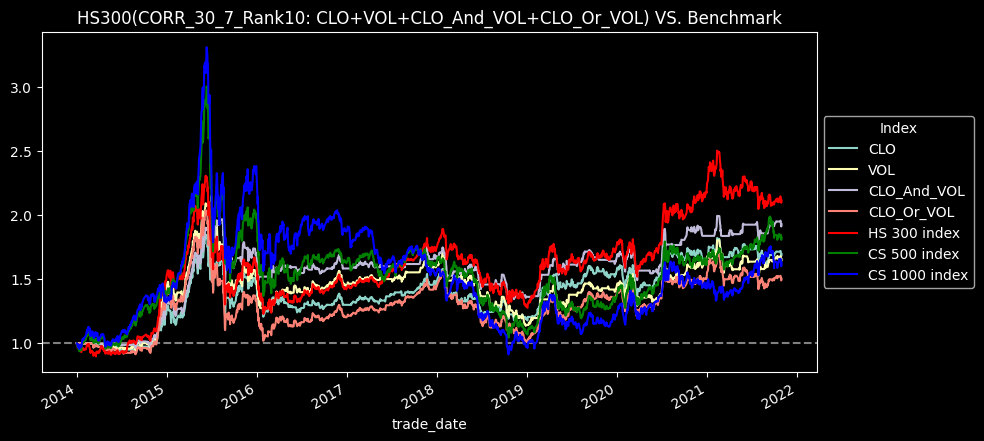

可以看出其中`CLO_And_VOL`因子表现最好。但整体都没有获得超额收益。

2. `HS300_CORR_30_7_Thr0.8_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

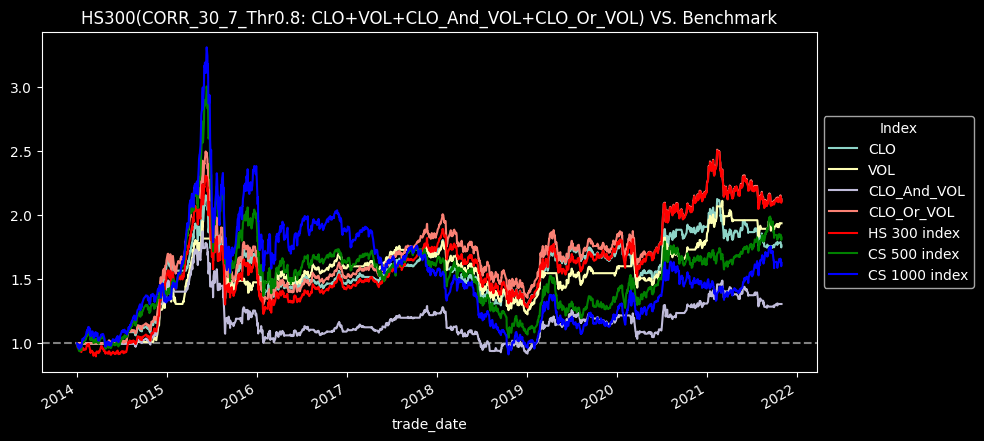

`VOL`因子表现最好，整体没有获得超额收益。相比于Rank10，`CLO_And_VOL`却表现得很差。

3. `HS300_CORR_30_7_Thr0.6_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

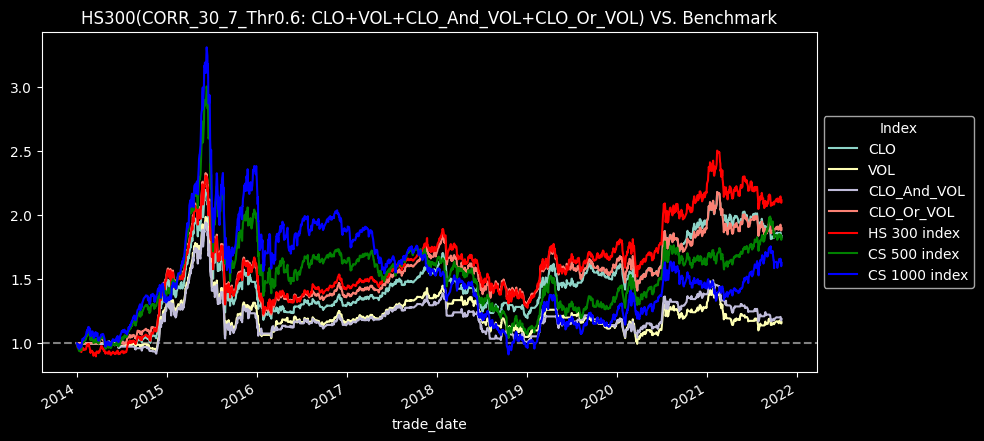

`CLO_Or_VOL`变现最好，且几乎与指数同涨同跌，β=0.76。

##### II: DTW算法

1. `HS300_DTW_30_7_Thr0.3_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

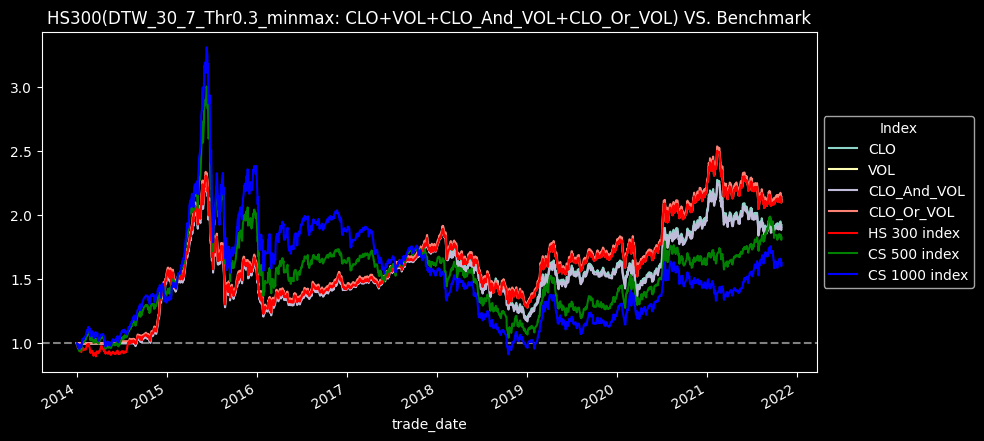

从图中可以看出，`CLO_Or_VOL`的表现最好，获得了少量的超额收益。其中`VOL`因子也获得了超额收益。

2. `HS300_DTW_30_7_Thr0.2_SC5_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

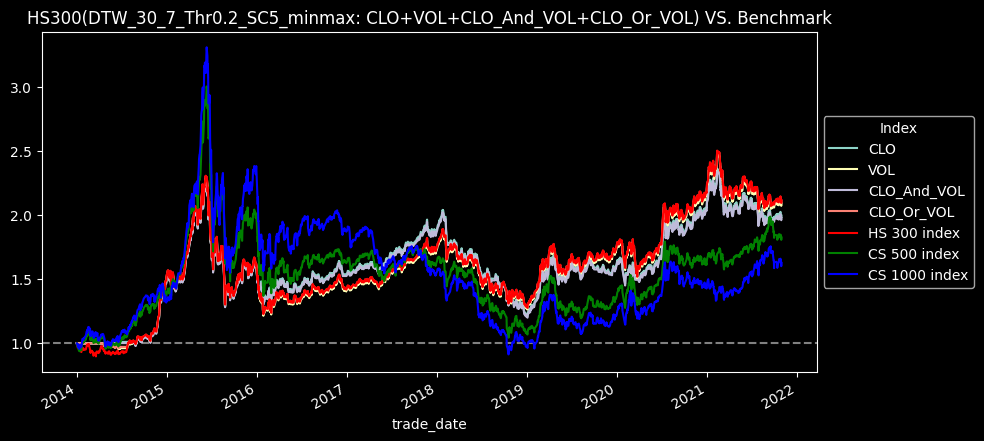

`CLO_Or_VOL`表现最好但也比沪深300指数要稍差。四个因子与指数都几乎同涨同跌。$\beta_{CLO} = 0.86, \beta_{VOL} = 0.97, \beta_{CLO\_And\_Or} = 0.85, \beta_{CLO\_Or\_VOL} = 0.98$

3. `HS300_DTW_30_7_Thr0.2_IP(0.5_2)_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

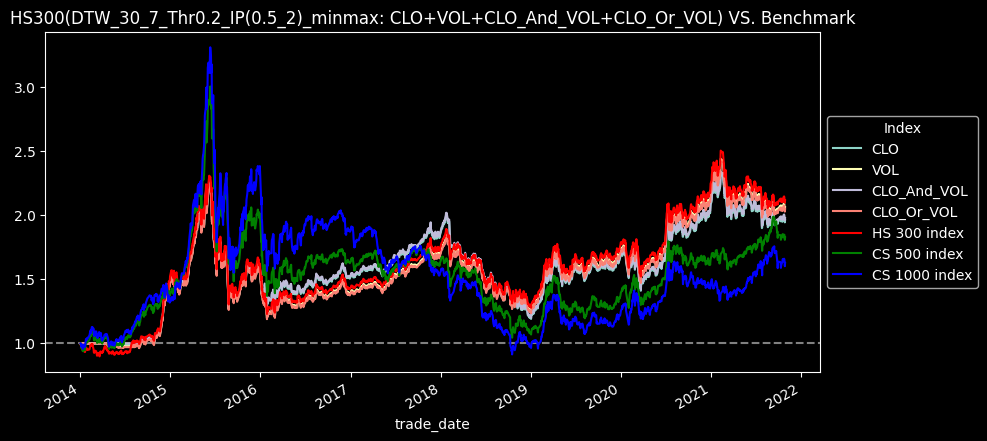

`VOL`因子最好，但都没有获得超额收益。

4. `HS300_DTW_30_7_Thr0.02_IP(0.5_2)_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

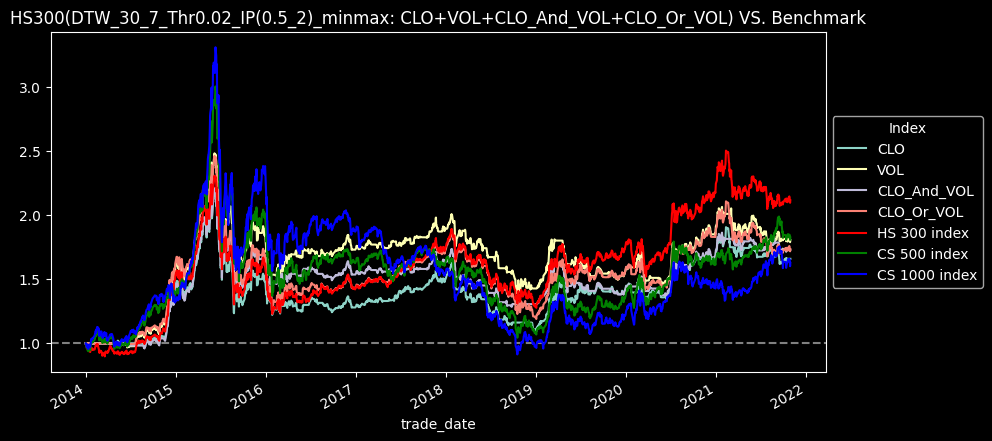

`VOL`因子一开始很强，但从2019年中旬开始跑输沪深300. 整体来看也是`VOL`的表现最好。但最后都没有获得超额收益。同时，相对于没有加边界限制的Thr0.02参数，Thr0.02_IP(0.5_2)参数整体的表现都要更优(见图5)，尤其是对于`VOL`因子来说.

5. `HS300_DTW_30_7_Thr0.02_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL`

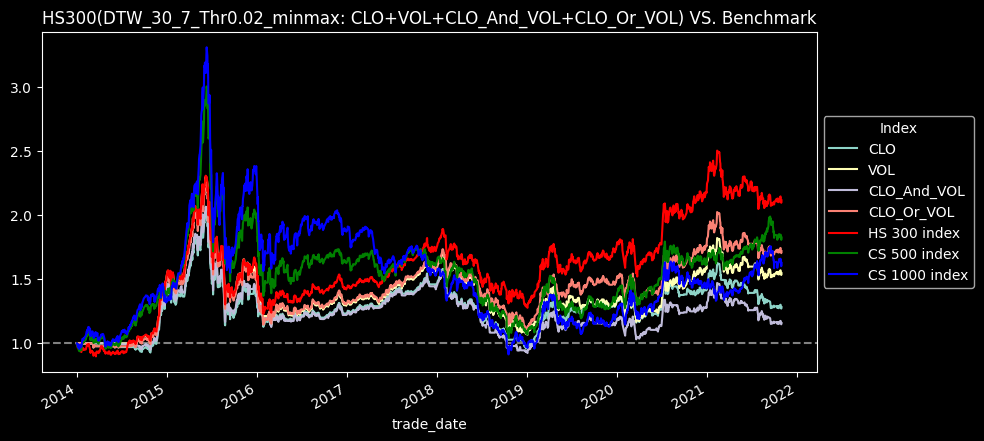

`CLO_Or_VOL`的表现最好。

6. `HS300_DTW_30_7_Thr0.02_SC5_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL.png`

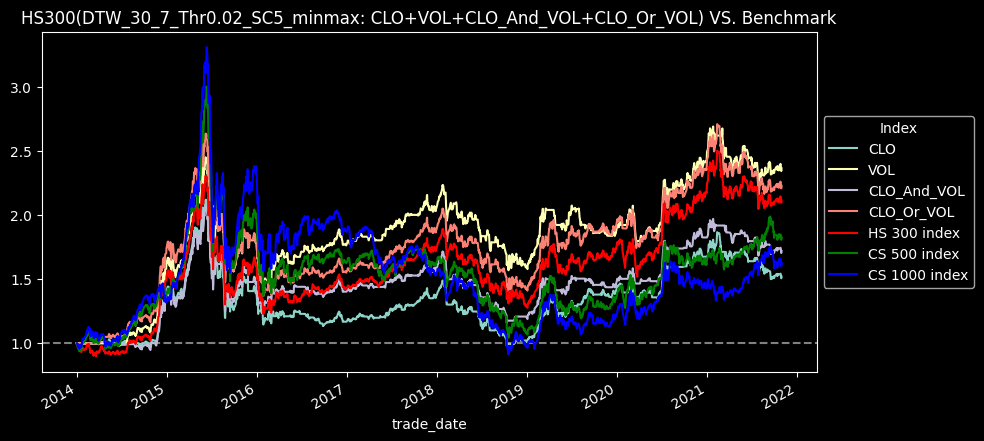

加了SC5参数后，`VOL`和`CLO_Or_VOL`的表现很突出，都获得了较多的超额收益，尤其是`VOL`因子。`VOL`因子总收益率为136.34%，年化12.05%（沪深300指数年化9.02%），夏普比率为0.44，β=1.07，α=0.01.

7. `HS300_DTW_30_7_Thr0.03_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL.png`

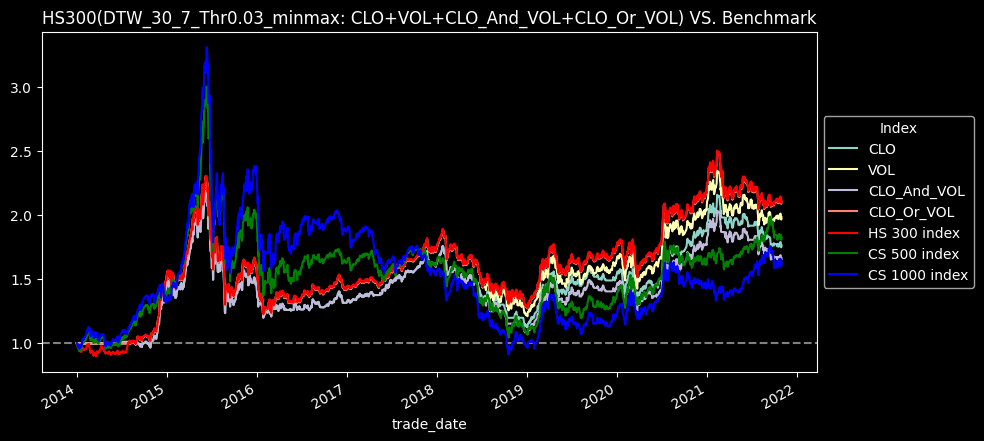

`VOL`因子表现最好，同时Thr0.03参数要优于Thr0.02参数.

9. `HS300_DTW_30_7_Rank10_minmax_CLO+VOL+CLO_And_VOL+CLO_Or_VOL.png`

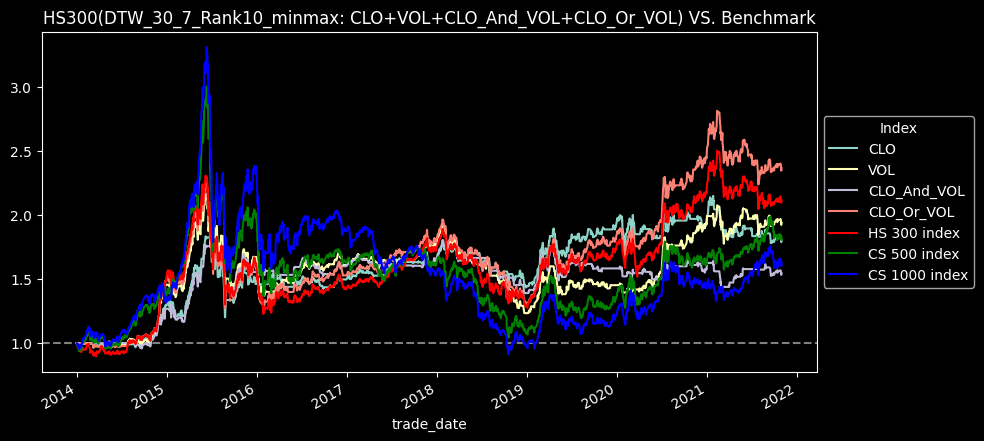

`CLO_Or_VOL`因子变现较好，获得了超额收益。

9. 纯M1和M2剪刀差因子

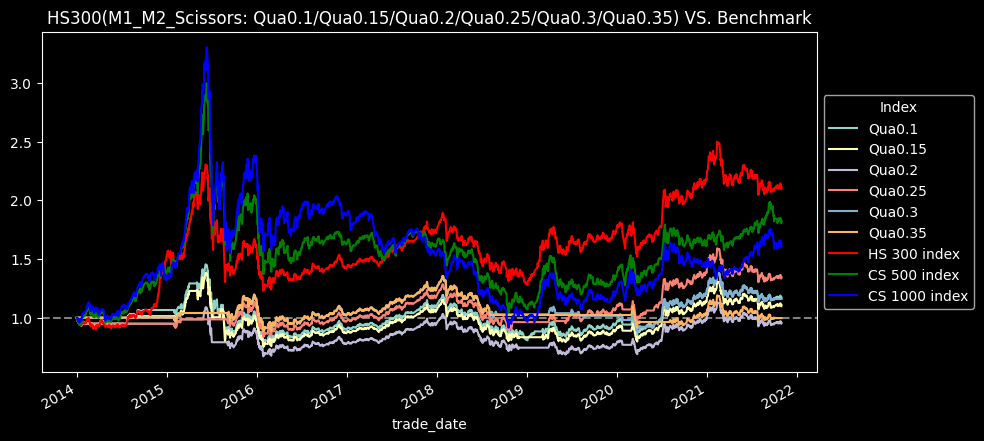

研报中的结果：

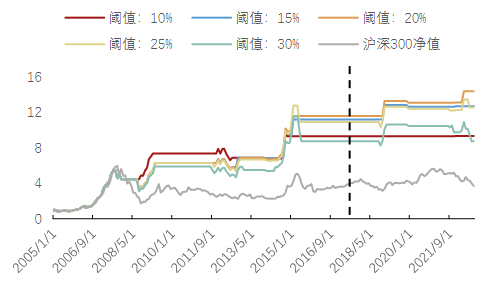

其中，表现最好的是分位值为*0.25*时的因子，与研报中的结果有出入。初步分析，是研报中剪刀差和指数数据是从2005年开始的；而本次实验中的剪刀差数据是从2000年开始的，而指数数据从2014年开始。

##### 11. `HS300CLO_DTW_30_7_Thr0.03` 与 `M1M2` 结合

A. CLO单因子

> `HS300_DTW_30_7_Thr0.03_minmax_CLO+CLO_Or_Qua0.1+CLO_Or_Qua0.15+CLO_Or_Qua0.2+CLO_Or_Qua0.25+CLO_Or_Qua0.3+CLO_Or_Qua0.35`

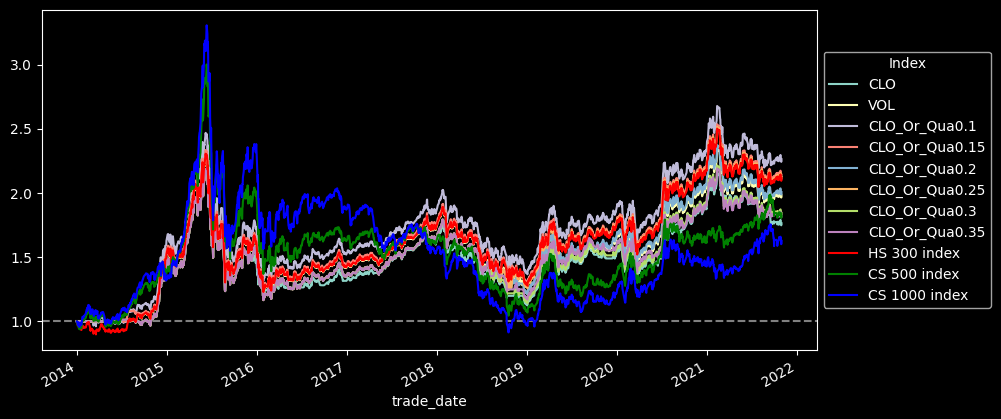

从图中可以看出，对于相对于CLO单因子，叠加宏观因子之后变现更加好。最好的是`CLO_Or_Qua0.1`，而不是`CLO_Or_Qua0.25`。说明说不能只通过研究M1M2就得出分位值为0.25的M1M2因子最好。在不同的DTW因子中，最优M1M2分位值不同。

B. VOL单因子

> `HS300_DTW_30_7_Thr0.03_minmax_VOL+VOL_Or_Qua0.1+VOL_Or_Qua0.15+VOL_Or_Qua0.2+VOL_Or_Qua0.25+VOL_Or_Qua0.3+VOL_Or_Qua0.35`

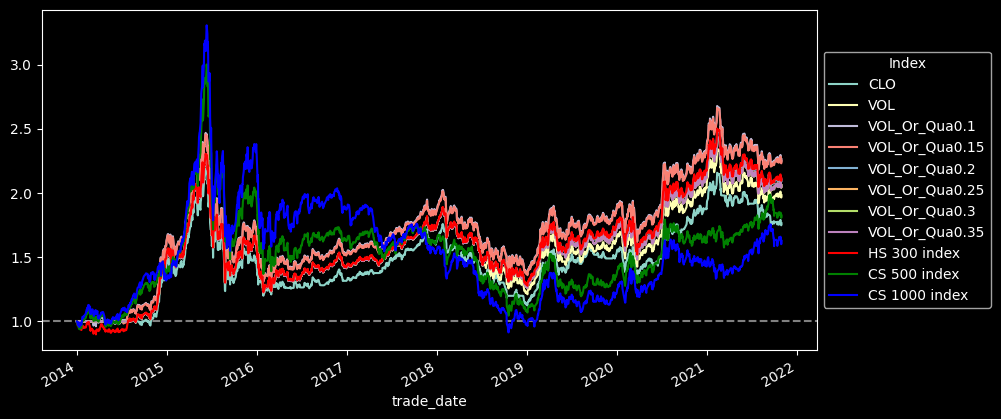

从图中可以看出，对于相对于VOL单因子，叠加宏观因子之后变现更加好。最好的是`VOL_Or_Qua0.1`和`VOL_Or_Qua0.15`.

C. CLO_And_VOL双因子

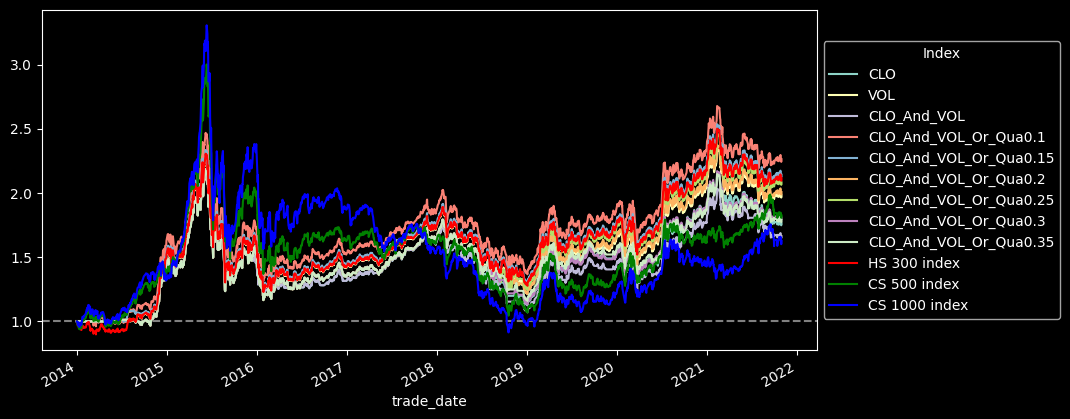

可以看出，相对于`CLO_And_VOL`，`CLO_And_VOL_Or_Qua0.1`的表现最好，获得了超额收益。

D. CLO_Or_VOL双因子

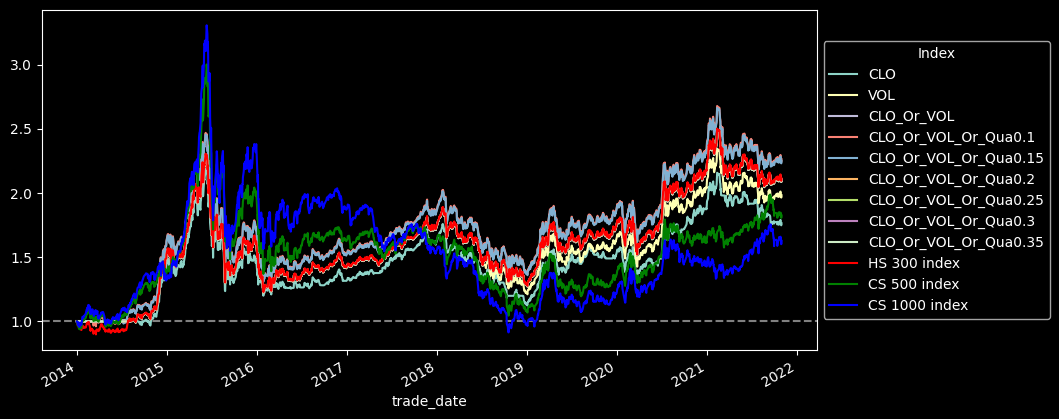

相比于`CLO_Or_VOL`，`CLO_Or_VOL_Or_Qua0.1`表现最好。

### 总结

在这次的DTW算法试验中，总体来看，DTW算法的要比单纯使用相关系数(Correlation)的效果好。在DTW算法中，发现大部分优秀的因子都是交易量`VOL`因子与`CLO_Or_VOL`因子，可能说明了使用交易量信号来做为指数时间序列的匹配更具有可靠性。同时也说明，因子的结合使用并集(`Or操作`)的方法比较好。在DTW与宏观M1和M2剪刀差的结合试验中发现，使用剪刀差数据后DTW的表现更加好，尤其是当分位值为`0.1`的时候。说明剪刀差数据对提高因子可靠性和降低风险具有一定的作用。

### 有待改进和补充的地方
- 增加在可以做空的条件下的回测功能
- 使用日频调仓 (会大大增加运行时间)
- 使用除沪深300指数之外的资产测试
- 测试新的超参数组合，找到DTW算法中最优的参数
- **改变回测时间，重点关注2023年以来至今的行情**